# Сборный проект

**Описание проекта**

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».


Привет, дорогой ревьювер! Спасибо тебе, что берешься проверить мою работу :-)

С уважением, Антон.

### Шаг 1. Откроем файлы с данными и изучим общую информацию. 

In [6]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from functools import reduce

Прочитаем файл *datasets/games.csv* и сохраним его в переменной *data*.


In [7]:
data = pd.read_csv('/datasets/games.csv')
data.head() # Выведем первые пять строк таблицы для визуального ознакомления.

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Общая информация о данных таблицы *data*.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Вывод

 - На начальном этапе мы можем видеть наличие пропусков, которые неоходимо заполнить (они могут быть как случайными, так и неслучайными.)
 - Нам предстоит заменить тип данных в некоторых столбцах: `Year_of_Release`, `User_Score`
 - Название столбцов необходимо привести к нижнему регистру.

### Шаг 2. Подготовка данных

#### Названия столбцов приведем к нижнему регистру:

In [9]:
data.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 
               'critic_score', 'user_score', 'rating']

#### Обработаем пропуски

Создадим функцию, для того, что бы определить какую часть составляют пропуски в столбцах.

In [10]:
def nan_part(row):
    return 'Пропуски составляют {:.2%}'.format(data[row].isna().sum() / len(data))

*Название игры*

Две строчки с пропущенными названиями игр будет лучше удалить, т.к. нет возможности определить название.

In [11]:
data.dropna(subset = ['name'], inplace=True)

*Год выпуска.*

Всего пропущено 269 значений, которые составляют 1.61% от всех данных столбца. С абсолютной точностью восстановить данные не представляется возможно, поэтому все пропущенные значения заменим на -1 и не будем использовать в дальнейшем анализе.

In [12]:
data['year_of_release'].isna().sum()

269

In [13]:
nan_part('year_of_release')

'Пропуски составляют 1.61%'

In [14]:
data['year_of_release'].fillna(-1, inplace=True)

*Пропущены значения оценок критиков и рейтингов ESRB*

Исходя из того, что аналогично весьма сложно заменить пропущенные значения, будет лучше привести их к -1.

In [15]:
nan_part('critic_score')

'Пропуски составляют 51.31%'

In [16]:
nan_part('rating')

'Пропуски составляют 40.47%'

In [17]:
for column in ['critic_score', 'rating']:
    data.loc[data[column].isna(), column] = -1

*Оценка пользователей*

С оценкой пользователей ситуация похожа на *год выпуска*: часть значений пропущена, а еще часть имеет значение 'tbd'. Их все так же будет лучше заменить на -1.

In [18]:
# data['user_score'].value_counts()

In [19]:
data.loc[(data['user_score'] == 'tbd') | (data['user_score'].isna()), 'user_score'] = -1

#### Преобразуем тип данных в столбцах
1. В столбце `year_of_release` заменим данные с вещественного на целочисленный тип.
2. В столбце `user_score` со строчного на вещественный. 

In [20]:
data['year_of_release'] = data['year_of_release'].astype('int')
data['user_score'] = pd.to_numeric(data['user_score'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null float64
user_score         16713 non-null float64
rating             16713 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


#### Суммарные продажи в регионах

In [21]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] 

data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,74.09
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,-1,39.47
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,32.23
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,29.82
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,-1,30.38


### Вывод

Таким образом мы заменили названия столбцов (все прописные буквы заменили на строчные), заменили типы данных в столбцах с годом выпуска и с оценкой пользователей ввиду их несоответсвия нужному типу.
Обработали пропущенные значения, из которых основную часть составляли пропуски оценки критиков и рейтинг от организации ESRB. Есть вероятность, что данные пропуски были образованы из-за того, что в те года, когда были выпущены игры еще не существовало ни игровых критико, ни организации ESRB.

### Шаг 3. Исследовательский анализ данных

**Определим, сколько игр выпускалось в разные года**

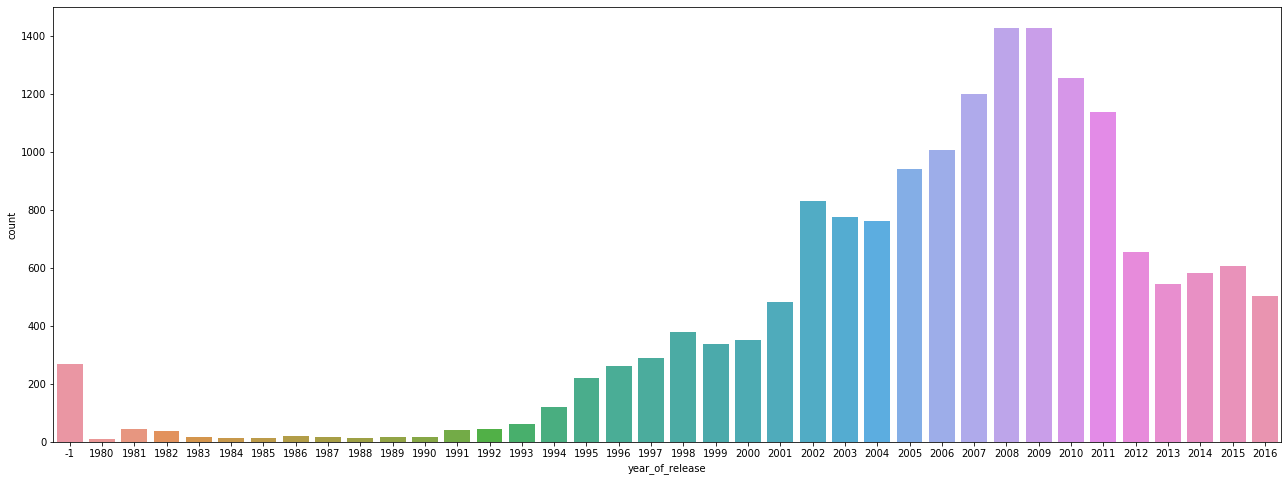

In [22]:
year_series = data.pivot_table(index='year_of_release', values='total_sales', aggfunc='count')
year_series.columns = ['count']

ax = plt.subplots(figsize=(22, 8))
ax = sns.barplot(x=year_series.index, y="count", data=year_series)

Исходя из графика, данные до 1994 года могут быть не интересны для нашего анализа.

**Продажи по платформам в разные года**

In [55]:
year_series = data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
year_series.fillna(0, inplace=True)
# year_series

Определим среднюю "продолжительность жизни" для платформ

In [56]:
# соберем список из количества лет жизни каждой платформы
notnull = []
for platform in year_series.columns:
    notnull.append(year_series[platform].ne(0).value_counts().loc[year_series[platform].ne(0).value_counts().index == True].values[0])

*Может есть более простой способ?*

Построим ящик с усами для продолжительности жизни каждой из платформ.

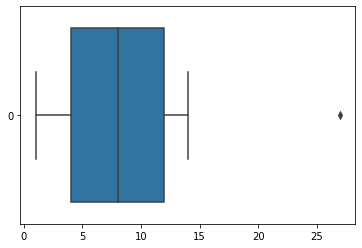

In [25]:
sns.boxplot(data=notnull, orient='h')

In [26]:
notnull = pd.DataFrame(notnull, columns=['active_years'])
notnull.describe()

,active_years
count,31.000000
mean,8.193548
std,5.412451
min,1.000000
25%,4.000000
50%,8.000000
75%,12.000000
max,27.000000


Таким образом мы можем видеть, что средняя продолжительность жизни игровой платформы, в течении которой она приносить доход  составляет 8 лет. 

**Определим Топ-10 платформ с наибольшими суммарными продажами**

In [59]:
top = data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
top = top.sort_values(by='total_sales', ascending=False)
top = top[:10]
top

,total_sales
platform,
PS2,1062.33
X360,885.66
Wii,828.44
PS3,803.97
DS,746.86
PS,689.95
GBA,310.12
PS4,265.79
PSP,252.63


Победителем становиться PS2.

Определим актуальный переиод.

In [28]:
# year_series

In [29]:
for platform in year_series.columns:
    if platform not in top.index:
        year_series.drop(platform, axis=1, inplace=True)
year_series = year_series[year_series.index >= 1994]
year_series

platform,DS,GBA,PS,PS2,PS3,PS4,PSP,Wii,X360,XB
year_of_release,,,,,,,,,,
1994,0.00,0.00,5.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1995,0.00,0.00,34.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1996,0.00,0.00,89.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1997,0.00,0.00,128.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1998,0.00,0.00,160.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1999,0.00,0.00,136.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2000,0.00,0.07,91.09,35.59,0.00,0.00,0.00,0.00,0.00,0.95
2001,0.00,59.62,33.42,149.65,0.00,0.00,0.00,0.00,0.00,21.63
2002,0.00,72.35,6.31,183.66,0.00,0.00,0.00,0.00,0.00,46.32


Внимательно изучив таблицу (особенно данные по последним годам), мы можем прийдти к выводу, что актульный период для нас - промежуток с 2013 по 2016 года включительно. Это период активной фазы для платформы PS4, в то время, как остальные платформы находяться на конечном этапе своего коммерческого существования и не принесут значительного вклада в 2017 году.

In [30]:
year_series.T

year_of_release,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,
DS,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,135.85,134.37,110.99,79.48,24.30,10.42,1.42,0.00,0.00,0.00
GBA,0.00,0.0,0.00,0.0,0.00,0.00,0.07,59.62,72.35,55.31,...,3.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PS,5.63,34.0,89.16,128.3,160.44,136.61,91.09,33.42,6.31,1.93,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PS2,0.00,0.0,0.00,0.0,0.00,0.00,35.59,149.65,183.66,163.62,...,52.30,34.59,16.24,4.44,0.35,0.00,0.00,0.00,0.00,0.00
PS3,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,62.48,101.78,113.08,121.36,135.22,90.87,95.85,40.88,14.70,3.23
PS4,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,22.12,84.22,100.44,59.01
PSP,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,38.32,29.81,31.46,31.44,16.98,7.56,3.10,0.24,0.12,0.00
Wii,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,139.22,156.33,189.43,117.73,54.37,20.22,7.87,3.45,1.05,0.17
X360,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,86.68,122.56,109.26,155.80,131.11,91.45,80.82,31.61,10.86,1.40


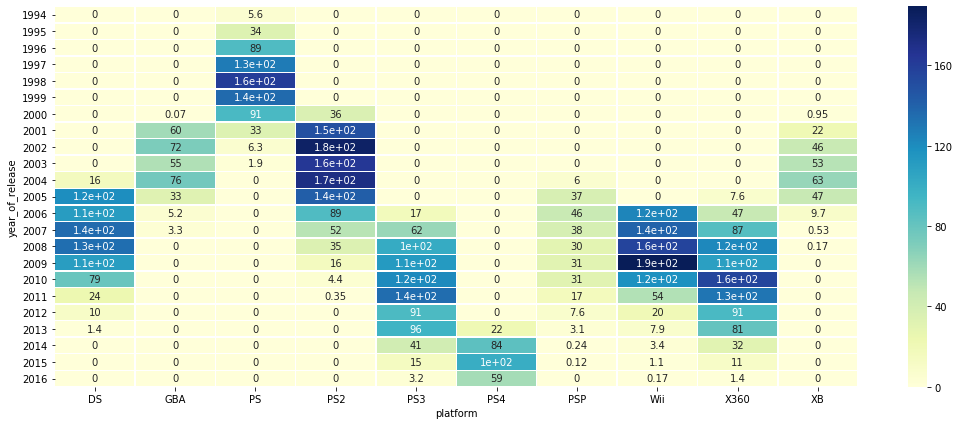

In [31]:
plt.figure(figsize=(18,7))
sns.heatmap(year_series, cmap='YlGnBu', linewidths=.5, annot=True)

In [1]:
# Оценка длительности продаж каждой платформы  

Более подробно рассмотрим период с 2013 по 2016 гг.

In [32]:
year_series = year_series[year_series.index >= 2013]
year_series

platform,DS,GBA,PS,PS2,PS3,PS4,PSP,Wii,X360,XB
year_of_release,,,,,,,,,,
2013,1.42,0.0,0.0,0.0,95.85,22.12,3.10,7.87,80.82,0.0
2014,0.00,0.0,0.0,0.0,40.88,84.22,0.24,3.45,31.61,0.0
2015,0.00,0.0,0.0,0.0,14.70,100.44,0.12,1.05,10.86,0.0
2016,0.00,0.0,0.0,0.0,3.23,59.01,0.00,0.17,1.40,0.0


Как уже и говоролось ранее, в своей активной коммерческой фазе пребывает PS4, тогда как лидеры по продажам 2013 года: PS3 и X360 к 2016 году уже исчерпали свой ресурс. Возможно PC еще может представлять для нас интерес.

**Глобальные продажи всех игр по платформам**

(0, 2)

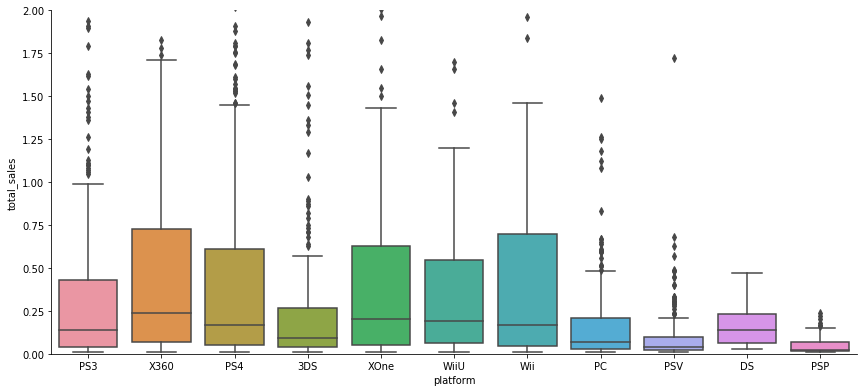

In [33]:
good_data = data.query('year_of_release >= 2013')
sns.catplot(x="platform", 
            y='total_sales', 
            kind="box", 
            data=good_data, 
            orient='v', 
            height=5.5, 
            aspect=2.2,
            )
plt.ylim(0, 2)

In [34]:
global_sales = good_data.pivot_table(index='platform', values='total_sales', aggfunc='sum')

global_sales = global_sales.sort_values(by='total_sales', ascending=False)
global_sales

,total_sales
platform,
PS4,265.79
PS3,154.66
XOne,145.05
3DS,136.97
X360,124.69
WiiU,59.94
PC,36.47
PSV,29.73
Wii,12.54


К лидерам по продажам за актуальный период (2013-2016 гг.) относятся PS4, PS3 и XOne.

**Влияние отзывов на продажи игр для платформы PS4**

Рассмотрим влияние отзывов пользователей и критиков на продажи игр для самой популярной платформы на период 2013-2016 гг.

In [35]:
ps_4 = good_data.query('platform == "PS4" and (user_score != -1) and (critic_score != -1)')
# ps_4.head()

Построим диаграммы рассеяния и посчитаем корреляцию между отзывами и продажами.

Text(0.5, 0, 'Рейтинг критиков')

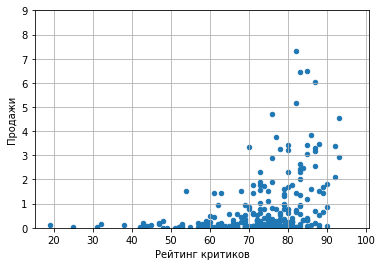

In [36]:
ps_4.plot(kind='scatter', x='critic_score', y='total_sales', grid=True)
plt.ylim(0, 9)
plt.ylabel('Продажи')
plt.xlabel('Рейтинг критиков')

In [37]:
# Определим коэффициент корреляции
round(ps_4['critic_score'].corr(ps_4['total_sales']), 2)

0.41

Text(0.5, 0, 'Рейтинг пользователей')

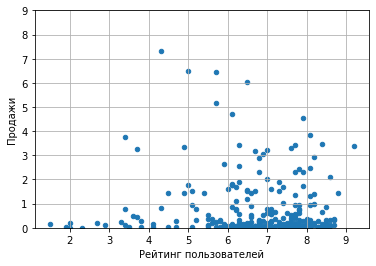

In [38]:
ps_4.plot(kind='scatter', x='user_score', y='total_sales', grid=True)
plt.ylim(0, 9)
plt.ylabel('Продажи')
plt.xlabel('Рейтинг пользователей')

In [39]:
# Определим коэффициент корреляции
round(ps_4['user_score'].corr(ps_4['total_sales']), 2)

-0.03

Как мы можем видеть, отзывы пользователей никак не влияют на продажи игр, в то время, кк отзывы критиков имеют некоторый вес: коэффициенты корреляции -0.03 и 0.41 соответственно.

Сравним выводы для PS4 с продажами для остальных платформ.

In [40]:
for platform in ['PS3', 'X360', 'PC', 'XOne']:
    
    print('\n{}:'.format(platform))
    
    for column in ['critic_score', 'user_score']:
        
        game_platform = good_data.query('platform == @platform and (user_score != -1) and (critic_score != -1)')
        
        print('Коэффициент корреляции между {0} и total_sales равен {1}'.
              format(column, round(game_platform[column].corr(game_platform['total_sales']), 2)))


PS3:
Коэффициент корреляции между critic_score и total_sales равен 0.34
Коэффициент корреляции между user_score и total_sales равен 0.02

X360:
Коэффициент корреляции между critic_score и total_sales равен 0.35
Коэффициент корреляции между user_score и total_sales равен -0.01

PC:
Коэффициент корреляции между critic_score и total_sales равен 0.2
Коэффициент корреляции между user_score и total_sales равен -0.11

XOne:
Коэффициент корреляции между critic_score и total_sales равен 0.41
Коэффициент корреляции между user_score и total_sales равен -0.09


#### Вывод

В качестве вывода скажем, что ситуация аналогична и для других платформ. Следовательно, **для всех платформ характерно среднее влияние отзывов критиков на продажи и практически полное отсутствие влияния отзывов пользователей**

(написал как то не совсем по русски :-))

**Распределим игры по жанрам**

In [41]:
genre_sales = good_data.pivot_table(index='genre', values='total_sales', aggfunc='sum')
genre_sales = genre_sales.sort_values(by='total_sales', ascending=False)
genre_sales

,total_sales
genre,
Action,284.67
Shooter,204.21
Role-Playing,134.41
Sports,131.20
Misc,56.73
Platform,38.51
Racing,35.45
Fighting,31.75
Adventure,21.21


(0, 2)

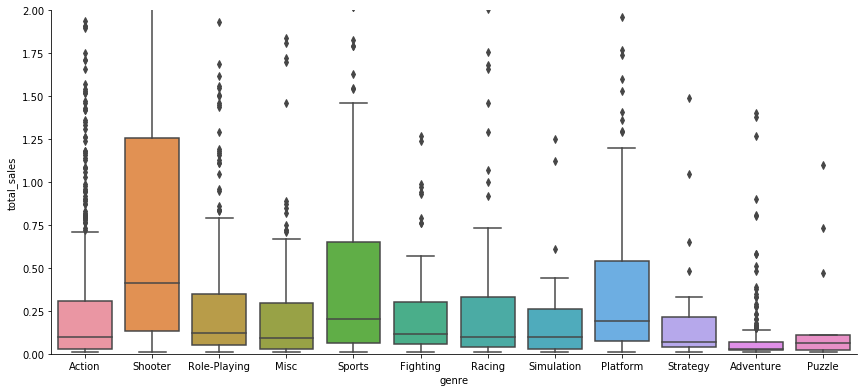

In [42]:
sns.catplot(x='genre',
           y='total_sales',
           kind='box',
           data=good_data,
           height=5.5,
           aspect=2.2)
plt.ylim(0, 2)

Как мы можем видеть по средним продажам лидирует жанр `Shooter`, в сравнении с остальными жанрами. А вот `Action` напротив отстает (по этому критерию), но является попклярным жанром из-за наибольшего объема продаж. Приключеньческие игры и головоломки занимают самую нишу как по абсолютным, так и по средним продажам: многие любят красивый боевик.

Ради интереса можно посмотреть, какие жанры у самых продаваемых игр за все время.

In [43]:
(data
 .pivot_table(index=['name', 'genre'], values='total_sales', aggfunc='sum')
 .sort_values(by='total_sales', ascending=False)
 .head())

,,total_sales
name,genre,
Wii Sports,Sports,74.09
Grand Theft Auto V,Action,48.68
Super Mario Bros.,Platform,44.32
Tetris,Puzzle,35.15
Mario Kart Wii,Racing,32.23


Удивительно!!! На первом месте не игры жанра Action или Shooter, а игра из жанра Sports. Action только на втором месте, а замыкает тройку лидеров жанр Platform.

### Шаг 4. Составим портрет пользователя каждого региона

1. **Топ-5 самых популярных платформ для Северной Америки, Европы и Японии**

In [44]:
# data.head()

In [45]:
for column in ['na_sales', 'eu_sales', 'jp_sales']:
    region = (good_data
            .pivot_table(index='platform', values=column, aggfunc='sum')
            .sort_values(by=column, ascending=False))
    region['ratio'] = round(region[column] / region[column].sum(), 2)
    print('\n', region[0:5])


           na_sales  ratio
platform                 
PS4         108.74   0.25
XOne         93.12   0.21
X360         81.66   0.19
PS3          63.50   0.15
3DS          38.20   0.09

           eu_sales  ratio
platform                 
PS4         141.09   0.36
PS3          67.81   0.17
XOne         51.59   0.13
X360         42.52   0.11
3DS          30.96   0.08

           jp_sales  ratio
platform                 
3DS          67.81   0.48
PS3          23.35   0.17
PSV          18.59   0.13
PS4          15.96   0.11
WiiU         10.88   0.08


Любопытно, что в то время, как набор Топ-5 платформ в Америке и Европе одинаковый и различается лишь долями продаж, то в Японии данный Топ координально отличается. (Люди с другой планеты...). 
Если в первых двух регионах лидиром являеется PS4, то  Японии данная платформа занимает лишь 4-е место. А на первом месте на Родине Самураев платформа 3DS, которая Америке и Европе на 5-ой позиции рейтинга. 

2. **Топ-5 самых популярных жанров для Северной Америки, Европы и Японии**

In [46]:
for column in ['na_sales', 'eu_sales', 'jp_sales']:
    region = (good_data
            .pivot_table(index='genre', values=column, aggfunc='sum')
            .sort_values(by=column, ascending=False))
    region['ratio'] = round(region[column] / region[column].sum(), 2)
    print('\n', region[0:5])


               na_sales  ratio
genre                        
Action          126.05   0.29
Shooter         109.74   0.25
Sports           65.27   0.15
Role-Playing     46.40   0.11
Misc             27.49   0.06

               eu_sales  ratio
genre                        
Action          118.13   0.30
Shooter          87.86   0.22
Sports           60.52   0.15
Role-Playing     36.97   0.09
Racing           20.19   0.05

               jp_sales  ratio
genre                        
Role-Playing     51.04   0.36
Action           40.49   0.29
Misc              9.20   0.07
Fighting          7.65   0.05
Shooter           6.61   0.05


Не удивительно, что и в жанрах игр Япония выделяется. Когда Топ-5 жанров в Америке и Европе отличается лишь 5-ой позицией: в Америке жанр Misc, а в Европе жанр Racing, Топ-5 в Японии координально отличается от вышеописанных. Обожаемый на западе и в Европе жанр Shooter в японском чарте находится на последнем - 5-ом месте. А жанр Role-Playing, котрый закрепился на 4-ом месте на континентах, в Стране Восходящего солнца является лидером.

3. **Влияние  рейтинга ESRB на продажи в отдельном регионе**

In [47]:
# good_data['rating'].value_counts()

Рейтинги ESRB (https://www.esrb.org/ratings-guide/):

- E - от 6 лет
- E10+ - от 10 лет
- T - от 13 лет
- M - от 17 лет

In [48]:
for column in ['na_sales', 'eu_sales', 'jp_sales']:
    region = (good_data[good_data['rating'] != -1]
            .pivot_table(index='rating', values=column, aggfunc='sum')
            .sort_values(by=column, ascending=False))
    region['ratio'] = round(region[column] / region[column].sum(), 2)
    print('\n', region[0:5])


         na_sales  ratio
rating                 
M         165.21   0.47
E          79.05   0.23
E10+       54.24   0.16
T          49.79   0.14

         eu_sales  ratio
rating                 
M         145.32   0.46
E          83.36   0.27
E10+       42.69   0.14
T          41.95   0.13

         jp_sales  ratio
rating                 
T          20.59   0.37
E          15.14   0.27
M          14.11   0.25
E10+        5.89   0.11


Запад и Восток вновь отличаются по популярности рейтингов: на Западе популярностью пользуются игры для лиц старше 17 лет, тогда как на Востоке первое место по продажам принадлежит играм для подростков (от 13 лет и старше). Значит ли это, что на Западе чаще всего играют люди более взрослые, чем на Востоке? Неизвестно, поскольку непонятно, соответствует ли возраст игроков разрешенному рейтингу. Интересно, что взрослые игры в Японии лишь на третьем месте по популярности. Второе местро и на Западе, и на Востоке принадлежит рейтингу E.

### Шаг 5. Проверим гипотезы

1. 

 - Нулевая гипотеза - средние пользовательские рейтинги платформ Xbox One и PC одинаковые. 
 - Альтернативная гипотеза - средние пользовательские рейтинги платформ Xbox One и PC разные.

In [49]:
good_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,17.09
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,14.86
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,-1,12.25
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1.0,-1.0,-1,13.82
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,10.65


In [50]:
xbox = good_data.query('platform == "XOne"')['user_score']
pc = good_data.query('platform == "PC"')['user_score']

alpha = .01

results = st.ttest_ind(
    xbox, 
    pc, 
    equal_var=False)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.19564149183065668
Не получилось отвергнуть нулевую гипотезу


In [51]:
xbox_vs_pc = good_data.query('platform == "XOne" or platform == "PC"')
xbox_vs_pc = xbox_vs_pc.pivot_table(index='platform', values='user_score')
xbox_vs_pc

,user_score
platform,
PC,4.961905
XOne,4.542105


Статистический тест показал, что мы не можем отвергать гипотезу о равенсте пользовательских рейтингов на платформах Xbox One и PC. Если бы мы утверждали, что рейтинг разный, то с вероятность, почти 20% могли допустить ошибку.

2. 

 - Нулевая гипотеза - Средние пользовательские рейтинги жанров Action и Sports одинаковые.
 - Альтернативная гипотеза - Средние пользовательские рейтинги жанров Action и Sports разные.

In [52]:
xbox = good_data.query('genre == "Action"')['user_score']
pc = good_data.query('genre == "Sports"')['user_score']

alpha = .01

results = st.ttest_ind(
    xbox, 
    pc, 
    equal_var=False)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.008445505365573194
Отвергаем нулевую гипотезу


In [53]:
action_vs_sports = good_data.query('genre == "Action" or genre == "Sports"')
action_vs_sports = action_vs_sports.pivot_table(index='genre', values='user_score')
action_vs_sports 

,user_score
genre,
Action,2.980157
Sports,3.664019


Подтвердить исходную гипотезу не получилось, следовательно можно утверждать в уверенностью на 99,15%, что средние пользовательские рейтинги жанров Action и Sports различаются. При прочих условиях, в процессе продвижения игр лучше уделить больше внимания жанру Sport.

### Шаг 6. Общий вывод

Проделанный нами анализ показал, что потенциально успешный продукт должен обладать рядом характеристик:
 - Для западного рынка игры должны быть разработаны на платформах PS4 и XOne, а для японского - на платформе 3DS.
 - Японские геймеры предпочитают игры жанра Role-Playing, в то время как для западных игроков лучше выпускать игры жанров Action и Shooter.
 - По рейтингу ESRB лучше отдавать предпочтение играм с рейтингом от 17 лет (если речь идет об Америке и Европе), и с рейтингом от 13 лет для Японии. Стоит обратить внимание на продвижении игр с разрешенным возрастом от 6 лет, но в таком случае будет сужен набор жанров.
 - Не стоит ориентироваться на оценки пользователей, поскольку они не играют значитильной роли, а вот оценкам критиков стоит уделить внимании, их отзывы имеют значение.